In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.65
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed,MaxPooling2D
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K


In [4]:

n=210527 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 #288個一組 (24小時一組)
MLP_unit = 64
currencynum=5
currency = ["BTC","DASH","ETH","LTC","XMR"]
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
#month = [0,10,20,30,40,50]
month2 = [397,425,456,486,517,547,578,609,639,670,700,731] #2017 365天
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
M=1

# 控制要不要存檔，1 : Yes, 0 : No
save = 1
epochs = 100
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出
btc = 423.51
DASH = 0.00778 * btc
ETH = 0.0021652 * btc
LTC = 0.00805792 * btc
XMR = 0.00105001 * btc

In [5]:
"""
 V
"""
"""
diff
"""
df = pd.read_csv('btc_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
btc5months = np.zeros(n)
for i in range(n):
    btc5months[i] = df[0][i]
df = pd.read_csv('DASH_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
dash5months = np.zeros(n)
for i in range(n):
    dash5months[i] = df[0][i]
df = pd.read_csv('ETH_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
eth5months = np.zeros(n)
for i in range(n):
    eth5months[i] = df[0][i]
df = pd.read_csv('LTC_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
ltc5months = np.zeros(n)
for i in range(n):
    ltc5months[i] = df[0][i]
df = pd.read_csv('XMR_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
xmr5months = np.zeros(n)
for i in range(n):
    xmr5months[i] = df[0][i]    
print('finish dataread')
Train_data=np.zeros(((n-l+1,len(currency),l)))
for p in range(n-l+1):
    Train_data[p,0,:]=btc5months[p:p+l]
    Train_data[p,1,:]=dash5months[p:p+l]
    Train_data[p,2,:]=eth5months[p:p+l]
    Train_data[p,3,:]=ltc5months[p:p+l]
    Train_data[p,4,:]=xmr5months[p:p+l]


(210527, 1)
(210527, 1)
(210527, 1)
(210527, 1)
(210527, 1)
finish dataread


In [6]:
"""""""""
str, onehotcode, company code轉換
"""""""""
currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [7]:
"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, condition,typeq):
    # set condition
    def rise_of_fall():
        #目前問題設定只有三種設定：前者大(big)-0、後者大(small)-1、一樣(s)-2
        tmp = np.eye((2))
        d = {0:tmp[0],1:tmp[1]}
        return d
    # 拼接問題
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)], rise_of_fall()[condition]))

qtype = ['big','small']
HVqtype = ['big','small']


"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((5,1))
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])/(btc + np.sum(btc5months[:n]))
    outcome[1]=(data2_sum[1])/(DASH + np.sum(dash5months[:n]))
    outcome[2]=(data2_sum[2])/(ETH + np.sum(eth5months[:n]))
    outcome[3]=(data2_sum[3])/(LTC + np.sum(ltc5months[:n]))
    outcome[4]=(data2_sum[4])/(XMR + np.sum(xmr5months[:n]))

    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
            
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i, all_question[0][0]))
        q_pair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #同漲
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
     
        a_pair[i] = tmp_a
        
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((5,1))
    #data_std=np.std(data,axis=1)
    data2_std=np.std(data2,axis=1)    
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
     
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
        
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i,all_question[1][0]))
        q_HVpair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #前者大
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
    
        a_HVpair[i] = tmp_a
        
    return (data, q_HVpair, a_HVpair)


In [8]:
"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(m1*288,m3*288-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))           
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print(v.shape)
    v = v.reshape(len(v),5,l,1)
    print(v.shape)
    print("[Training model......]")
    
    #Train_v=v[:]
    
    Train_v=v[:((m2-m1)*288-72)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)*288-72)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)*288-72)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a,validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==40):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==40):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])

    """
    再依據問法(大or小)分割
    """
    flag=0
    big_trend=[]
    small_trend=[]
    big_vol=[]
    small_vol=[]
    big_count=0
    small_count=0
    for ii in range(0,len(q_trend)):
        if(flag==0):
            #print(0)
            big_trend.append(a_trend[ii])
            big_vol.append(a_vol[ii])
            big_count=big_count+1
            if(big_count==20):
                big_count=0
                flag=1
        elif(flag==1):
            #print(1)
            small_trend.append(a_trend[ii])
            small_vol.append(a_vol[ii])
            small_count=small_count+1
            if(small_count==20):
                small_count=0
                flag=0
    
    """
    比對互補矛盾
    """
    anscount1=0
    for u in range(len(big_trend)):
        if(big_trend[u]==small_trend[u]):
            anscount1=anscount1+1
            print("trend筆數:")
            print(i)
            print("big:")
            print(big_trend[i])
            print("small")
            print(small_trend[i])
    anscount2=0
    for u in range(len(big_vol)):
        if(big_vol[u]==small_vol[u]):
            anscount2=anscount2+1
            print("vol筆數:")
            print(i)
            print("big:")
            print(big_vol[i])
            print("small")
            print(small_vol[i])
    
    if(anscount1==0):
        print("trend沒有異常")
    if(anscount2==0):
        print("vol沒有異常")

    """
    算benchmark
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("benchacc:")
    print(benchacc)
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []


In [10]:
def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,5)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
9
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6464 MiB, count=2, average=3232 MiB
(2824320, 60, 5)
(2824320, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 704640 samples
Epoch 1/100
2113920/2113920 [==============================] - 25s 12us/step - loss: 0.9147 - acc: 0.5016 - val_loss: 0.7958 - val_acc: 0.5109
Epoch 2/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.6957 - acc: 0.5233 - val_loss: 0.6931 - val_acc: 0.5747
Epoch 3/100
2113920/2113920 [==============================] - 21s 10us/step - loss: 0.6485 - acc: 0.6016 - val_loss: 0.6200 - val_acc: 0.6563
Epoch 4/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.5653 - acc: 0.6732 - val_loss: 0.5530 - val_acc: 0.6814
Epoch 5/100
2113920/2113920 [==============================] - 21s 10us/step - loss: 0.5114 - acc: 0.6955 - val_

Epoch 56/100
2113920/2113920 [==============================] - 21s 10us/step - loss: 0.4449 - acc: 0.7160 - val_loss: 0.5043 - val_acc: 0.7072
Epoch 57/100
2113920/2113920 [==============================] - 21s 10us/step - loss: 0.4450 - acc: 0.7161 - val_loss: 0.5041 - val_acc: 0.7066
Epoch 58/100
2113920/2113920 [==============================] - 21s 10us/step - loss: 0.4449 - acc: 0.7159 - val_loss: 0.4986 - val_acc: 0.7089
Epoch 59/100
2113920/2113920 [==============================] - 21s 10us/step - loss: 0.4449 - acc: 0.7157 - val_loss: 0.4908 - val_acc: 0.7097
Epoch 60/100
2113920/2113920 [==============================] - 21s 10us/step - loss: 0.4448 - acc: 0.7158 - val_loss: 0.4904 - val_acc: 0.7093
Epoch 61/100
2113920/2113920 [==============================] - 21s 10us/step - loss: 0.4447 - acc: 0.7160 - val_loss: 0.4886 - val_acc: 0.7097
Epoch 62/100
2113920/2113920 [==============================] - 21s 10us/step - loss: 0.4448 - acc: 0.7164 - val_loss: 0.4846 - val_acc:

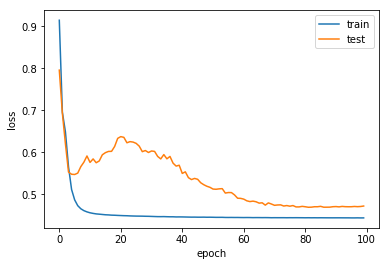

acc:
0.7182566038413802
val_acc:
0.715623580835604


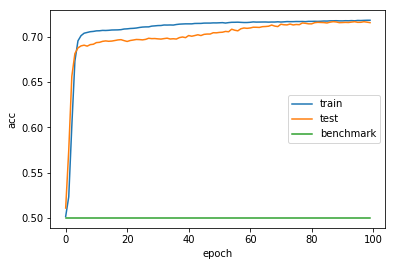

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
10
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6306 MiB, count=134, average=47.1 MiB
(2755200, 60, 5)
(2755200, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 635520 samples
Epoch 1/100
2113920/2113920 [==============================] - 26s 12us/step - loss: 1.1221 - acc: 0.5014 - val_loss: 0.6969 - val_acc: 0.5213
Epoch 2/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.7055 - acc: 0.5108 - val_loss: 0.6879 - val_acc: 0.5516
Epoch 3/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.6873 - acc: 0.5360 - val_loss: 0.6695 - val_acc: 0.6186
Epoch 4/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.6452 - acc: 0.6056 - val_loss: 0.5627 - val_acc: 0.7214
Epoch 5/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.5536 - acc: 0.6806 - v

Epoch 56/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.4387 - acc: 0.7121 - val_loss: 0.4125 - val_acc: 0.7341
Epoch 57/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.4386 - acc: 0.7124 - val_loss: 0.4120 - val_acc: 0.7349
Epoch 58/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.4387 - acc: 0.7115 - val_loss: 0.4120 - val_acc: 0.7346
Epoch 59/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.4386 - acc: 0.7122 - val_loss: 0.4119 - val_acc: 0.7345
Epoch 60/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.4385 - acc: 0.7117 - val_loss: 0.4118 - val_acc: 0.7349
Epoch 61/100
2113920/2113920 [==============================] - 21s 10us/step - loss: 0.4385 - acc: 0.7123 - val_loss: 0.4120 - val_acc: 0.7353
Epoch 62/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.4385 - acc: 0.7116 - val_loss: 0.4119 - val_acc:

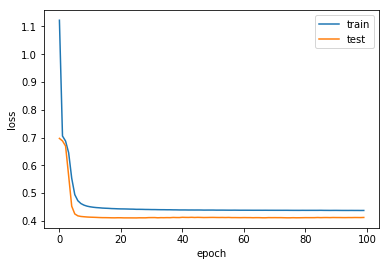

acc:
0.7143278837420527
val_acc:
0.7372985901429214


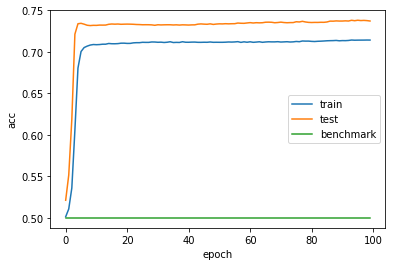

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
11
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6359 MiB, count=137, average=46.4 MiB
(2778240, 60, 5)
(2778240, 5, 60, 1)
[Training model......]
Train on 2067840 samples, validate on 704640 samples
Epoch 1/100
2067840/2067840 [==============================] - 27s 13us/step - loss: 0.9819 - acc: 0.5059 - val_loss: 0.6950 - val_acc: 0.5391
Epoch 2/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.6890 - acc: 0.5445 - val_loss: 0.6657 - val_acc: 0.6032
Epoch 3/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.6167 - acc: 0.6452 - val_loss: 0.5851 - val_acc: 0.6700
Epoch 4/100
2067840/2067840 [==============================] - 22s 10us/step - loss: 0.5239 - acc: 0.7037 - val_loss: 0.5196 - val_acc: 0.6863
Epoch 5/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4744 - acc: 0.7167 - v

Epoch 56/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4263 - acc: 0.7268 - val_loss: 0.4730 - val_acc: 0.6963
Epoch 57/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4265 - acc: 0.7269 - val_loss: 0.4735 - val_acc: 0.6965
Epoch 58/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4261 - acc: 0.7273 - val_loss: 0.4721 - val_acc: 0.6962
Epoch 59/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4260 - acc: 0.7267 - val_loss: 0.4731 - val_acc: 0.6966
Epoch 60/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4261 - acc: 0.7271 - val_loss: 0.4711 - val_acc: 0.6963
Epoch 61/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4259 - acc: 0.7268 - val_loss: 0.4710 - val_acc: 0.6963
Epoch 62/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4258 - acc: 0.7269 - val_loss: 0.4708 - val_acc:

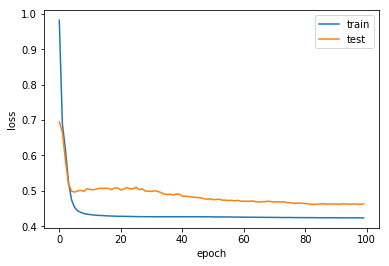

acc:
0.7293562364187155
val_acc:
0.6946795526793824


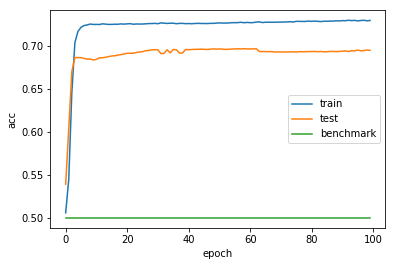

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6306 MiB, count=139, average=45.4 MiB
(2755200, 60, 5)
(2755200, 5, 60, 1)
[Training model......]
Train on 2067840 samples, validate on 681600 samples
Epoch 1/100
2067840/2067840 [==============================] - 27s 13us/step - loss: 0.8415 - acc: 0.5042 - val_loss: 0.6918 - val_acc: 0.5054
Epoch 2/100
2067840/2067840 [==============================] - 22s 10us/step - loss: 0.6891 - acc: 0.5298 - val_loss: 0.6787 - val_acc: 0.5688
Epoch 3/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.6405 - acc: 0.6165 - val_loss: 0.6099 - val_acc: 0.6642
Epoch 4/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.5608 - acc: 0.6872 - val_loss: 0.5156 - val_acc: 0.6873
Epoch 5/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4943 - acc: 0.7098 - v

Epoch 56/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4153 - acc: 0.7358 - val_loss: 0.4586 - val_acc: 0.7164
Epoch 57/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4152 - acc: 0.7360 - val_loss: 0.4582 - val_acc: 0.7164
Epoch 58/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4151 - acc: 0.7362 - val_loss: 0.4590 - val_acc: 0.7166
Epoch 59/100
2067840/2067840 [==============================] - 22s 10us/step - loss: 0.4151 - acc: 0.7362 - val_loss: 0.4587 - val_acc: 0.7167
Epoch 60/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4150 - acc: 0.7363 - val_loss: 0.4593 - val_acc: 0.7172
Epoch 61/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4150 - acc: 0.7365 - val_loss: 0.4607 - val_acc: 0.7173
Epoch 62/100
2067840/2067840 [==============================] - 22s 11us/step - loss: 0.4147 - acc: 0.7362 - val_loss: 0.4617 - val_acc:

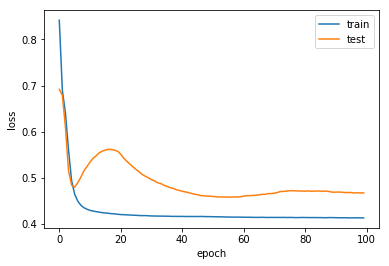

acc:
0.737964252505425
val_acc:
0.7215038145204106


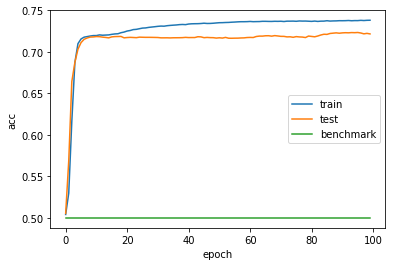

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6306 MiB, count=139, average=45.4 MiB
(2755200, 60, 5)
(2755200, 5, 60, 1)
[Training model......]
Train on 2044800 samples, validate on 704640 samples
Epoch 1/100
2044800/2044800 [==============================] - 27s 13us/step - loss: 0.8526 - acc: 0.5024 - val_loss: 0.7066 - val_acc: 0.5096
Epoch 2/100
2044800/2044800 [==============================] - 22s 11us/step - loss: 0.7011 - acc: 0.5141 - val_loss: 0.7001 - val_acc: 0.5178
Epoch 3/100
2044800/2044800 [==============================] - 22s 11us/step - loss: 0.6753 - acc: 0.5626 - val_loss: 0.6849 - val_acc: 0.5610
Epoch 4/100
2044800/2044800 [==============================] - 22s 11us/step - loss: 0.5980 - acc: 0.6655 - val_loss: 0.6442 - val_acc: 0.6066
Epoch 5/100
2044800/2044800 [==============================] - 22s 11us/step - loss: 0.4980 - acc: 0.7121 - v

Epoch 56/100
2044800/2044800 [==============================] - 22s 11us/step - loss: 0.4205 - acc: 0.7254 - val_loss: 0.5791 - val_acc: 0.6535
Epoch 57/100
2044800/2044800 [==============================] - 22s 11us/step - loss: 0.4206 - acc: 0.7250 - val_loss: 0.5815 - val_acc: 0.6514
Epoch 58/100
2044800/2044800 [==============================] - 21s 10us/step - loss: 0.4203 - acc: 0.7248 - val_loss: 0.5805 - val_acc: 0.6514
Epoch 59/100
2044800/2044800 [==============================] - 22s 11us/step - loss: 0.4207 - acc: 0.7244 - val_loss: 0.5776 - val_acc: 0.6511
Epoch 60/100
2044800/2044800 [==============================] - 22s 11us/step - loss: 0.4206 - acc: 0.7245 - val_loss: 0.5721 - val_acc: 0.6522
Epoch 61/100
2044800/2044800 [==============================] - 22s 11us/step - loss: 0.4204 - acc: 0.7250 - val_loss: 0.5672 - val_acc: 0.6541
Epoch 62/100
2044800/2044800 [==============================] - 22s 11us/step - loss: 0.4203 - acc: 0.7255 - val_loss: 0.5733 - val_acc:

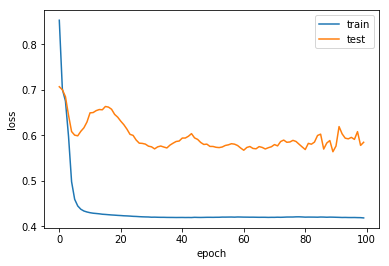

acc:
0.7279103090729512
val_acc:
0.6697803133514987


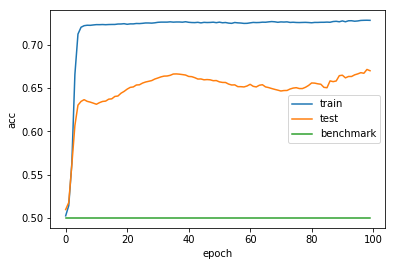

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6412 MiB, count=139, average=46.1 MiB
(2801280, 60, 5)
(2801280, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 681600 samples
Epoch 1/100
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.8909 - acc: 0.5011 - val_loss: 0.6940 - val_acc: 0.5172
Epoch 2/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.7021 - acc: 0.5061 - val_loss: 0.6902 - val_acc: 0.5357
Epoch 3/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.6902 - acc: 0.5273 - val_loss: 0.6758 - val_acc: 0.5828
Epoch 4/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.6590 - acc: 0.5992 - val_loss: 0.6050 - val_acc: 0.6747
Epoch 5/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.5776 - acc: 0.6745 - v

Epoch 56/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.4311 - acc: 0.7163 - val_loss: 0.4369 - val_acc: 0.6927
Epoch 57/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4312 - acc: 0.7160 - val_loss: 0.4369 - val_acc: 0.6926
Epoch 58/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4313 - acc: 0.7159 - val_loss: 0.4370 - val_acc: 0.6927
Epoch 59/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4311 - acc: 0.7160 - val_loss: 0.4369 - val_acc: 0.6927
Epoch 60/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.4312 - acc: 0.7162 - val_loss: 0.4371 - val_acc: 0.6927
Epoch 61/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.4311 - acc: 0.7158 - val_loss: 0.4369 - val_acc: 0.6926
Epoch 62/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.4311 - acc: 0.7159 - val_loss: 0.4369 - val_acc:

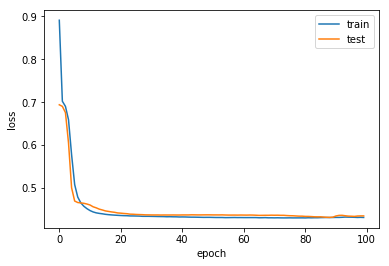

acc:
0.7183181009724253
val_acc:
0.7021875000447735


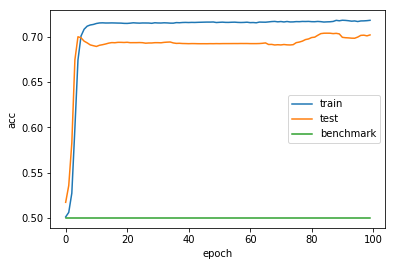

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6412 MiB, count=139, average=46.1 MiB
(2801280, 60, 5)
(2801280, 5, 60, 1)
[Training model......]
Train on 2090880 samples, validate on 704640 samples
Epoch 1/100
2090880/2090880 [==============================] - 29s 14us/step - loss: 1.0168 - acc: 0.5021 - val_loss: 0.6961 - val_acc: 0.5137
Epoch 2/100
2090880/2090880 [==============================] - 22s 11us/step - loss: 0.7017 - acc: 0.5100 - val_loss: 0.6896 - val_acc: 0.5225
Epoch 3/100
2090880/2090880 [==============================] - 23s 11us/step - loss: 0.6879 - acc: 0.5334 - val_loss: 0.6772 - val_acc: 0.5498
Epoch 4/100
2090880/2090880 [==============================] - 22s 11us/step - loss: 0.6644 - acc: 0.5863 - val_loss: 0.6301 - val_acc: 0.6308
Epoch 5/100
2090880/2090880 [==============================] - 23s 11us/step - loss: 0.6053 - acc: 0.6527 - v

Epoch 56/100
2090880/2090880 [==============================] - 22s 11us/step - loss: 0.4297 - acc: 0.7090 - val_loss: 0.4379 - val_acc: 0.6988
Epoch 57/100
2090880/2090880 [==============================] - 22s 11us/step - loss: 0.4296 - acc: 0.7087 - val_loss: 0.4377 - val_acc: 0.6986
Epoch 58/100
2090880/2090880 [==============================] - 22s 10us/step - loss: 0.4294 - acc: 0.7088 - val_loss: 0.4374 - val_acc: 0.6986
Epoch 59/100
2090880/2090880 [==============================] - 22s 11us/step - loss: 0.4295 - acc: 0.7089 - val_loss: 0.4374 - val_acc: 0.6984
Epoch 60/100
2090880/2090880 [==============================] - 22s 11us/step - loss: 0.4294 - acc: 0.7084 - val_loss: 0.4370 - val_acc: 0.6986
Epoch 61/100
2090880/2090880 [==============================] - 22s 11us/step - loss: 0.4295 - acc: 0.7094 - val_loss: 0.4366 - val_acc: 0.6986
Epoch 62/100
2090880/2090880 [==============================] - 22s 11us/step - loss: 0.4293 - acc: 0.7093 - val_loss: 0.4360 - val_acc:

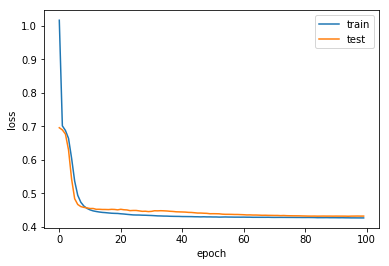

acc:
0.7123297367688527
val_acc:
0.7020308242506812


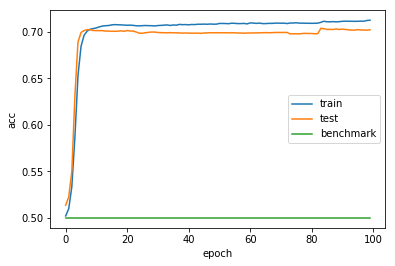

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6464 MiB, count=139, average=46.5 MiB
(2824320, 60, 5)
(2824320, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 704640 samples
Epoch 1/100
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.9137 - acc: 0.5022 - val_loss: 0.6985 - val_acc: 0.5181
Epoch 2/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.6994 - acc: 0.5136 - val_loss: 0.6867 - val_acc: 0.5534
Epoch 3/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.6790 - acc: 0.5581 - val_loss: 0.6549 - val_acc: 0.6213
Epoch 4/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.6173 - acc: 0.6484 - val_loss: 0.5805 - val_acc: 0.6628
Epoch 5/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.5404 - acc: 0.6898 - v

Epoch 56/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4261 - acc: 0.7090 - val_loss: 0.4725 - val_acc: 0.6940
Epoch 57/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.4259 - acc: 0.7092 - val_loss: 0.4725 - val_acc: 0.6938
Epoch 58/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4259 - acc: 0.7089 - val_loss: 0.4730 - val_acc: 0.6937
Epoch 59/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4258 - acc: 0.7090 - val_loss: 0.4726 - val_acc: 0.6937
Epoch 60/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4259 - acc: 0.7090 - val_loss: 0.4725 - val_acc: 0.6932
Epoch 61/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4260 - acc: 0.7088 - val_loss: 0.4726 - val_acc: 0.6932
Epoch 62/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.4259 - acc: 0.7090 - val_loss: 0.4729 - val_acc:

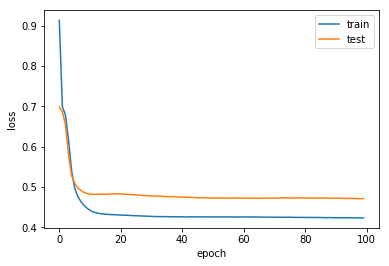

acc:
0.7090906940696097
val_acc:
0.6876986830154405


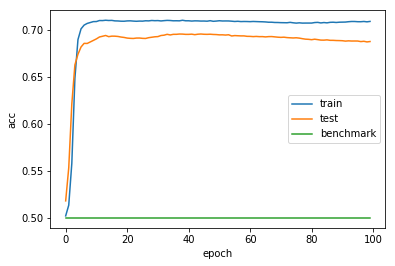

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
17
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6412 MiB, count=139, average=46.1 MiB
(2801280, 60, 5)
(2801280, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 681600 samples
Epoch 1/100
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.8692 - acc: 0.5014 - val_loss: 0.6956 - val_acc: 0.5097
Epoch 2/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.7012 - acc: 0.5083 - val_loss: 0.6906 - val_acc: 0.5491
Epoch 3/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.6777 - acc: 0.5503 - val_loss: 0.6469 - val_acc: 0.6434
Epoch 4/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.6146 - acc: 0.6447 - val_loss: 0.5689 - val_acc: 0.7014
Epoch 5/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.5488 - acc: 0.6863 - v

Epoch 56/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4292 - acc: 0.7095 - val_loss: 0.4395 - val_acc: 0.7094
Epoch 57/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.4291 - acc: 0.7092 - val_loss: 0.4398 - val_acc: 0.7094
Epoch 58/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4290 - acc: 0.7093 - val_loss: 0.4397 - val_acc: 0.7087
Epoch 59/100
2113920/2113920 [==============================] - 22s 10us/step - loss: 0.4291 - acc: 0.7095 - val_loss: 0.4393 - val_acc: 0.7092
Epoch 60/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.4289 - acc: 0.7095 - val_loss: 0.4395 - val_acc: 0.7069
Epoch 61/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4288 - acc: 0.7104 - val_loss: 0.4395 - val_acc: 0.7076
Epoch 62/100
2113920/2113920 [==============================] - 22s 11us/step - loss: 0.4287 - acc: 0.7108 - val_loss: 0.4391 - val_acc:

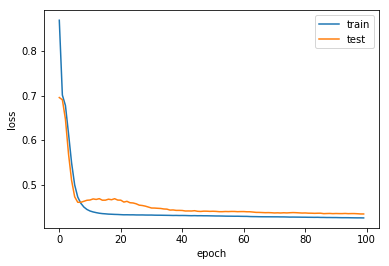

acc:
0.715193574027224
val_acc:
0.7088394953051643


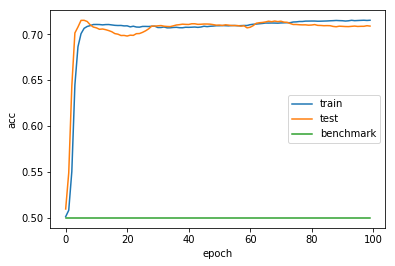

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
18
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6464 MiB, count=139, average=46.5 MiB
(2824320, 60, 5)
(2824320, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 704640 samples
Epoch 1/100
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.8782 - acc: 0.5006 - val_loss: 0.6987 - val_acc: 0.4952
Epoch 2/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.7043 - acc: 0.5042 - val_loss: 0.6943 - val_acc: 0.5104
Epoch 3/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.6937 - acc: 0.5135 - val_loss: 0.6887 - val_acc: 0.5406
Epoch 4/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.6797 - acc: 0.5480 - val_loss: 0.6453 - val_acc: 0.6427
Epoch 5/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.6134 - acc: 0.6435 - v

Epoch 56/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4197 - acc: 0.7195 - val_loss: 0.3907 - val_acc: 0.7562
Epoch 57/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4196 - acc: 0.7193 - val_loss: 0.3906 - val_acc: 0.7561
Epoch 58/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4194 - acc: 0.7197 - val_loss: 0.3907 - val_acc: 0.7560
Epoch 59/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4195 - acc: 0.7197 - val_loss: 0.3911 - val_acc: 0.7565
Epoch 60/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4193 - acc: 0.7198 - val_loss: 0.3907 - val_acc: 0.7560
Epoch 61/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4192 - acc: 0.7198 - val_loss: 0.3904 - val_acc: 0.7558
Epoch 62/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.4192 - acc: 0.7196 - val_loss: 0.3902 - val_acc:

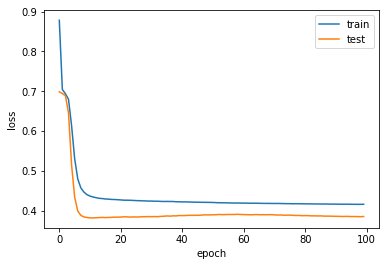

acc:
0.7220126589428032
val_acc:
0.7572760558583106


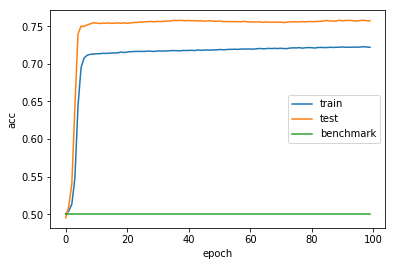

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
19
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6412 MiB, count=139, average=46.1 MiB
(2801280, 60, 5)
(2801280, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 681600 samples
Epoch 1/100
2113920/2113920 [==============================] - 30s 14us/step - loss: 1.2647 - acc: 0.5020 - val_loss: 0.7224 - val_acc: 0.5062
Epoch 2/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.7239 - acc: 0.5109 - val_loss: 0.7016 - val_acc: 0.5280
Epoch 3/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.6888 - acc: 0.5383 - val_loss: 0.6812 - val_acc: 0.5773
Epoch 4/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.6448 - acc: 0.6087 - val_loss: 0.6308 - val_acc: 0.6463
Epoch 5/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.5682 - acc: 0.6765 - v

Epoch 56/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.3951 - acc: 0.7405 - val_loss: 0.5247 - val_acc: 0.7281
Epoch 57/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.3950 - acc: 0.7403 - val_loss: 0.5220 - val_acc: 0.7281
Epoch 58/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.3947 - acc: 0.7409 - val_loss: 0.5183 - val_acc: 0.7280
Epoch 59/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.3948 - acc: 0.7405 - val_loss: 0.5149 - val_acc: 0.7283
Epoch 60/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.3949 - acc: 0.7405 - val_loss: 0.5118 - val_acc: 0.7285
Epoch 61/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.3949 - acc: 0.7407 - val_loss: 0.5164 - val_acc: 0.7283
Epoch 62/100
2113920/2113920 [==============================] - 23s 11us/step - loss: 0.3948 - acc: 0.7411 - val_loss: 0.5130 - val_acc:

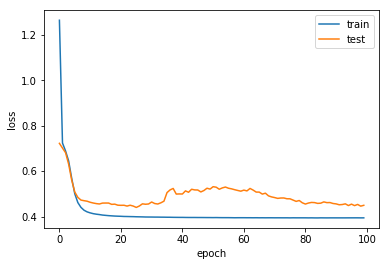

acc:
0.7453030389076357
val_acc:
0.7334081572490119


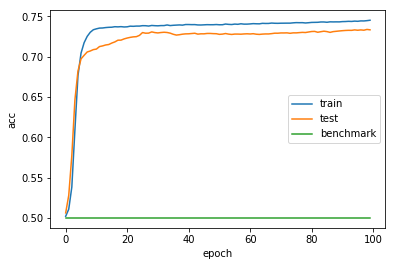

train_acc:red,test_acc:blue


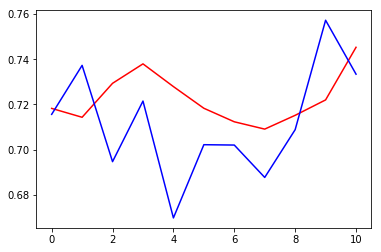

train_loss:red,test_loss:blue


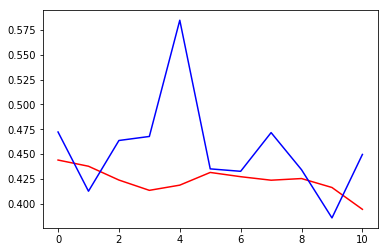

trend:red,vol:blue


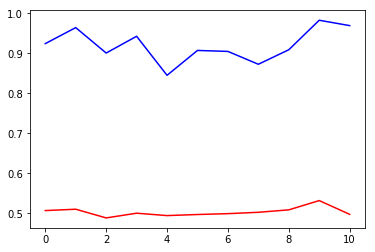

In [11]:

for i in range(9,20,1):

    MLP_unit=64
    visual_scene = Input((currencynum,l,1))
    visual_conv = ConvolutionNetworks([20,10],[(1,5),(1,5)])(visual_scene)
    print(K.int_shape(visual_conv))
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([tag, visual_conv])
    print(K.int_shape(visual_conv))
    
    shapes = visual_conv.shape
    w = shapes[1]
    f = shapes[2]
    features= []
    #features = np.zeros(0)
    for k1 in range(w):
        for k2 in range(f):
            def get_feature(t):
                return t[:, k1, k2, :]
            #get_feature_layer = Lambda(get_feature)
            features.append(Lambda(get_feature)(visual_conv))
    
      
    input2 = Input((14,))
    onehot_encode_question = input2
    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode_question]))    
    
     
    g_MLP = get_MLP(4, get_dense(4,MLP_unit))
    
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))
    
    combined_relation = Add()(mid_relations)
    
    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')
    
    pred = Dense(1, activation = 'sigmoid')(rn)
    
    
    #model = Model(inputs=[visual_scene])
    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(i)
    fit_show(Train_data,month[i],month[i+3],month[i+4])

print("train_acc:red,test_acc:blue")    
plt.plot(lastepoch_train_acc,color='r')
plt.plot(lastepoch_test_acc,color='b')
plt.show()
print("train_loss:red,test_loss:blue")
plt.plot(lastepoch_train_loss,color='r')
plt.plot(lastepoch_test_loss,color='b')
plt.show()
print("trend:red,vol:blue")
plt.plot(total_test_trend,color='r')
plt.plot(total_test_vol,color='b')
plt.show()

In [12]:
epochs=300

In [13]:
"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(m1*288,m3*288-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))           
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print(v.shape)
    v = v.reshape(len(v),5,l,1)
    print(v.shape)
    print("[Training model......]")
    
    #Train_v=v[:]
    
    Train_v=v[:((m2-m1)*288-72)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)*288-72)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)*288-72)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a,validation_data=([Train_v,Train_q],Train_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==40):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==40):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])

    """
    再依據問法(大or小)分割
    """
    flag=0
    big_trend=[]
    small_trend=[]
    big_vol=[]
    small_vol=[]
    big_count=0
    small_count=0
    for ii in range(0,len(q_trend)):
        if(flag==0):
            #print(0)
            big_trend.append(a_trend[ii])
            big_vol.append(a_vol[ii])
            big_count=big_count+1
            if(big_count==20):
                big_count=0
                flag=1
        elif(flag==1):
            #print(1)
            small_trend.append(a_trend[ii])
            small_vol.append(a_vol[ii])
            small_count=small_count+1
            if(small_count==20):
                small_count=0
                flag=0
    
    """
    比對互補矛盾
    """
    anscount1=0
    for u in range(len(big_trend)):
        if(big_trend[u]==small_trend[u]):
            anscount1=anscount1+1
            print("trend筆數:")
            print(i)
            print("big:")
            print(big_trend[i])
            print("small")
            print(small_trend[i])
    anscount2=0
    for u in range(len(big_vol)):
        if(big_vol[u]==small_vol[u]):
            anscount2=anscount2+1
            print("vol筆數:")
            print(i)
            print("big:")
            print(big_vol[i])
            print("small")
            print(small_vol[i])
    
    if(anscount1==0):
        print("trend沒有異常")
    if(anscount2==0):
        print("vol沒有異常")

    """
    算benchmark
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("benchacc:")
    print(benchacc)
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
9
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6464 MiB, count=139, average=46.5 MiB
(2824320, 60, 5)
(2824320, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 2113920 samples
Epoch 1/300
2113920/2113920 [==============================] - 35s 17us/step - loss: 0.8489 - acc: 0.5041 - val_loss: 0.6923 - val_acc: 0.5279
Epoch 2/300
2113920/2113920 [==============================] - 29s 13us/step - loss: 0.6930 - acc: 0.5276 - val_loss: 0.6726 - val_acc: 0.6022
Epoch 3/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6516 - acc: 0.6040 - val_loss: 0.6019 - val_acc: 0.6992
Epoch 4/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.5865 - acc: 0.6727 - val_loss: 0.5145 - val_acc: 0.7089
Epoch 5/300
2113920/2113920 [==============================] - 29s 13us/step - loss: 0.5200 - acc: 0.6946 - v

Epoch 56/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4443 - acc: 0.7145 - val_loss: 0.4437 - val_acc: 0.7213
Epoch 57/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4444 - acc: 0.7147 - val_loss: 0.4438 - val_acc: 0.7214
Epoch 58/300
2113920/2113920 [==============================] - 28s 13us/step - loss: 0.4442 - acc: 0.7148 - val_loss: 0.4435 - val_acc: 0.7215
Epoch 59/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4442 - acc: 0.7150 - val_loss: 0.4437 - val_acc: 0.7214
Epoch 60/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4442 - acc: 0.7148 - val_loss: 0.4437 - val_acc: 0.7215
Epoch 61/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4440 - acc: 0.7146 - val_loss: 0.4437 - val_acc: 0.7216
Epoch 62/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4442 - acc: 0.7150 - val_loss: 0.4439 - val_acc:

Epoch 113/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4428 - acc: 0.7170 - val_loss: 0.4454 - val_acc: 0.7226
Epoch 114/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4430 - acc: 0.7168 - val_loss: 0.4454 - val_acc: 0.7224
Epoch 115/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4429 - acc: 0.7169 - val_loss: 0.4455 - val_acc: 0.7224
Epoch 116/300
2113920/2113920 [==============================] - 28s 13us/step - loss: 0.4428 - acc: 0.7175 - val_loss: 0.4455 - val_acc: 0.7222
Epoch 117/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4428 - acc: 0.7169 - val_loss: 0.4455 - val_acc: 0.7226
Epoch 118/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4428 - acc: 0.7171 - val_loss: 0.4455 - val_acc: 0.7224
Epoch 119/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4428 - acc: 0.7174 - val_loss: 0.4457 - v

2113920/2113920 [==============================] - 28s 13us/step - loss: 0.4401 - acc: 0.7204 - val_loss: 0.4458 - val_acc: 0.7224
Epoch 226/300
2113920/2113920 [==============================] - 28s 13us/step - loss: 0.4402 - acc: 0.7205 - val_loss: 0.4460 - val_acc: 0.7225
Epoch 227/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4399 - acc: 0.7207 - val_loss: 0.4460 - val_acc: 0.7225
Epoch 228/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4400 - acc: 0.7209 - val_loss: 0.4458 - val_acc: 0.7224
Epoch 229/300
2113920/2113920 [==============================] - 28s 13us/step - loss: 0.4401 - acc: 0.7208 - val_loss: 0.4459 - val_acc: 0.7222
Epoch 230/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4400 - acc: 0.7210 - val_loss: 0.4459 - val_acc: 0.7225
Epoch 231/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4399 - acc: 0.7204 - val_loss: 0.4457 - val_acc: 0.7222

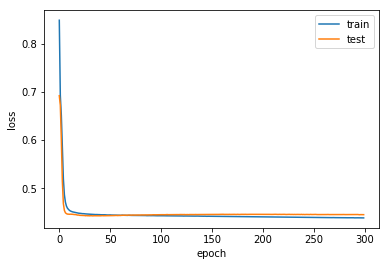

acc:
0.7218546586436573
val_acc:
0.7222047191946716


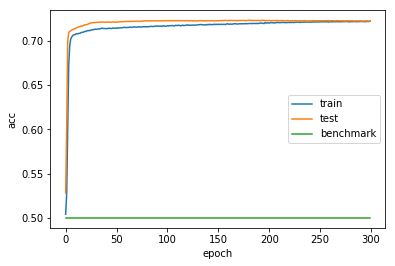

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
10
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6306 MiB, count=139, average=45.4 MiB
(2755200, 60, 5)
(2755200, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 2113920 samples
Epoch 1/300
2113920/2113920 [==============================] - 36s 17us/step - loss: 0.9521 - acc: 0.5005 - val_loss: 0.6971 - val_acc: 0.5231
Epoch 2/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.7078 - acc: 0.5065 - val_loss: 0.6899 - val_acc: 0.5408
Epoch 3/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6914 - acc: 0.5236 - val_loss: 0.6736 - val_acc: 0.5935
Epoch 4/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6529 - acc: 0.5952 - val_loss: 0.5770 - val_acc: 0.6956
Epoch 5/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.5620 - acc: 0.6822 - 

Epoch 56/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4375 - acc: 0.7173 - val_loss: 0.4586 - val_acc: 0.7211
Epoch 57/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4374 - acc: 0.7172 - val_loss: 0.4584 - val_acc: 0.7212
Epoch 58/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4374 - acc: 0.7171 - val_loss: 0.4579 - val_acc: 0.7210
Epoch 59/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4373 - acc: 0.7171 - val_loss: 0.4577 - val_acc: 0.7210
Epoch 60/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4375 - acc: 0.7176 - val_loss: 0.4567 - val_acc: 0.7216
Epoch 61/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4373 - acc: 0.7172 - val_loss: 0.4570 - val_acc: 0.7215
Epoch 62/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4374 - acc: 0.7175 - val_loss: 0.4571 - val_acc:

Epoch 113/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4364 - acc: 0.7198 - val_loss: 0.4452 - val_acc: 0.7239
Epoch 114/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4365 - acc: 0.7200 - val_loss: 0.4449 - val_acc: 0.7243
Epoch 115/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4366 - acc: 0.7197 - val_loss: 0.4449 - val_acc: 0.7242
Epoch 116/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4365 - acc: 0.7201 - val_loss: 0.4449 - val_acc: 0.7242
Epoch 117/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4365 - acc: 0.7199 - val_loss: 0.4446 - val_acc: 0.7242
Epoch 118/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4366 - acc: 0.7195 - val_loss: 0.4447 - val_acc: 0.7241
Epoch 119/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4365 - acc: 0.7195 - val_loss: 0.4444 - v

2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4348 - acc: 0.7226 - val_loss: 0.4418 - val_acc: 0.7244
Epoch 226/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4346 - acc: 0.7226 - val_loss: 0.4419 - val_acc: 0.7236
Epoch 227/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4347 - acc: 0.7220 - val_loss: 0.4419 - val_acc: 0.7237
Epoch 228/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4346 - acc: 0.7223 - val_loss: 0.4420 - val_acc: 0.7240
Epoch 229/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4346 - acc: 0.7225 - val_loss: 0.4418 - val_acc: 0.7244
Epoch 230/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4345 - acc: 0.7221 - val_loss: 0.4418 - val_acc: 0.7245
Epoch 231/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4345 - acc: 0.7223 - val_loss: 0.4420 - val_acc: 0.7242

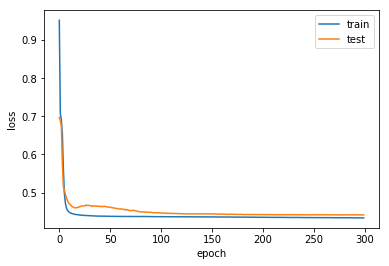

acc:
0.7232307750529822
val_acc:
0.7264404518583346


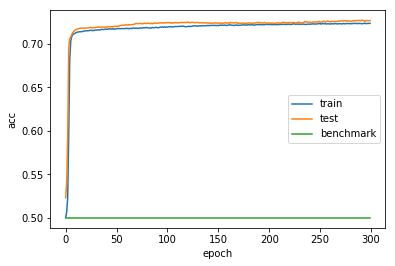

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
11
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6359 MiB, count=139, average=45.7 MiB
(2778240, 60, 5)
(2778240, 5, 60, 1)
[Training model......]
Train on 2067840 samples, validate on 2067840 samples
Epoch 1/300
2067840/2067840 [==============================] - 36s 17us/step - loss: 0.9097 - acc: 0.5064 - val_loss: 0.6872 - val_acc: 0.5508
Epoch 2/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.6971 - acc: 0.5331 - val_loss: 0.6574 - val_acc: 0.6444
Epoch 3/300
2067840/2067840 [==============================] - 28s 13us/step - loss: 0.6379 - acc: 0.6153 - val_loss: 0.5501 - val_acc: 0.7062
Epoch 4/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.5397 - acc: 0.6975 - val_loss: 0.4666 - val_acc: 0.7215
Epoch 5/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4800 - acc: 0.7172 - 

Epoch 56/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4247 - acc: 0.7338 - val_loss: 0.4337 - val_acc: 0.7344
Epoch 57/300
2067840/2067840 [==============================] - 28s 13us/step - loss: 0.4246 - acc: 0.7333 - val_loss: 0.4337 - val_acc: 0.7346
Epoch 58/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4245 - acc: 0.7335 - val_loss: 0.4338 - val_acc: 0.7344
Epoch 59/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4243 - acc: 0.7335 - val_loss: 0.4336 - val_acc: 0.7346
Epoch 60/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4243 - acc: 0.7341 - val_loss: 0.4336 - val_acc: 0.7346
Epoch 61/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4243 - acc: 0.7337 - val_loss: 0.4334 - val_acc: 0.7349
Epoch 62/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4243 - acc: 0.7336 - val_loss: 0.4334 - val_acc:

Epoch 113/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4229 - acc: 0.7354 - val_loss: 0.4291 - val_acc: 0.7369
Epoch 114/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4229 - acc: 0.7355 - val_loss: 0.4290 - val_acc: 0.7370
Epoch 115/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4229 - acc: 0.7354 - val_loss: 0.4290 - val_acc: 0.7366
Epoch 116/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4229 - acc: 0.7355 - val_loss: 0.4290 - val_acc: 0.7369
Epoch 117/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4230 - acc: 0.7351 - val_loss: 0.4289 - val_acc: 0.7370
Epoch 118/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4229 - acc: 0.7356 - val_loss: 0.4289 - val_acc: 0.7369
Epoch 119/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4229 - acc: 0.7350 - val_loss: 0.4289 - v

2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4218 - acc: 0.7377 - val_loss: 0.4279 - val_acc: 0.7359
Epoch 226/300
2067840/2067840 [==============================] - 28s 13us/step - loss: 0.4218 - acc: 0.7378 - val_loss: 0.4277 - val_acc: 0.7360
Epoch 227/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4218 - acc: 0.7376 - val_loss: 0.4278 - val_acc: 0.7358
Epoch 228/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4218 - acc: 0.7374 - val_loss: 0.4279 - val_acc: 0.7359
Epoch 229/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4216 - acc: 0.7376 - val_loss: 0.4280 - val_acc: 0.7359
Epoch 230/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4218 - acc: 0.7383 - val_loss: 0.4280 - val_acc: 0.7359
Epoch 231/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4218 - acc: 0.7377 - val_loss: 0.4282 - val_acc: 0.7359

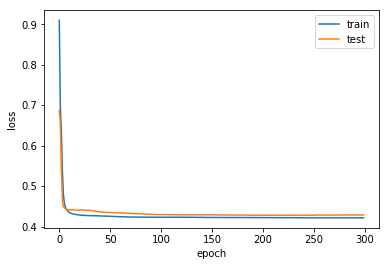

acc:
0.7376658735353487
val_acc:
0.7359694173224605


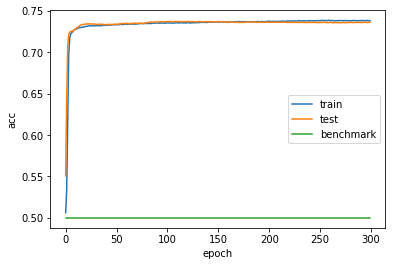

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6306 MiB, count=139, average=45.4 MiB
(2755200, 60, 5)
(2755200, 5, 60, 1)
[Training model......]
Train on 2067840 samples, validate on 2067840 samples
Epoch 1/300
2067840/2067840 [==============================] - 36s 18us/step - loss: 0.8641 - acc: 0.5012 - val_loss: 0.6973 - val_acc: 0.5056
Epoch 2/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.7024 - acc: 0.5132 - val_loss: 0.6854 - val_acc: 0.5491
Epoch 3/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.6645 - acc: 0.5785 - val_loss: 0.6197 - val_acc: 0.6827
Epoch 4/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.5778 - acc: 0.6777 - val_loss: 0.5214 - val_acc: 0.7010
Epoch 5/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.5023 - acc: 0.7098 - 

Epoch 56/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4135 - acc: 0.7399 - val_loss: 0.4711 - val_acc: 0.7221
Epoch 57/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4136 - acc: 0.7396 - val_loss: 0.4710 - val_acc: 0.7223
Epoch 58/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4134 - acc: 0.7398 - val_loss: 0.4703 - val_acc: 0.7220
Epoch 59/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4135 - acc: 0.7400 - val_loss: 0.4700 - val_acc: 0.7219
Epoch 60/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4134 - acc: 0.7400 - val_loss: 0.4707 - val_acc: 0.7216
Epoch 61/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4134 - acc: 0.7402 - val_loss: 0.4688 - val_acc: 0.7215
Epoch 62/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4132 - acc: 0.7399 - val_loss: 0.4696 - val_acc:

Epoch 113/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4119 - acc: 0.7428 - val_loss: 0.4649 - val_acc: 0.7184
Epoch 114/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4119 - acc: 0.7430 - val_loss: 0.4663 - val_acc: 0.7181
Epoch 115/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4118 - acc: 0.7435 - val_loss: 0.4659 - val_acc: 0.7190
Epoch 116/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4120 - acc: 0.7433 - val_loss: 0.4664 - val_acc: 0.7190
Epoch 117/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4118 - acc: 0.7432 - val_loss: 0.4679 - val_acc: 0.7180
Epoch 118/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4120 - acc: 0.7431 - val_loss: 0.4675 - val_acc: 0.7177
Epoch 119/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4118 - acc: 0.7433 - val_loss: 0.4685 - v

2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4070 - acc: 0.7461 - val_loss: 0.5197 - val_acc: 0.7116
Epoch 226/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4071 - acc: 0.7461 - val_loss: 0.5215 - val_acc: 0.7117
Epoch 227/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4069 - acc: 0.7462 - val_loss: 0.5224 - val_acc: 0.7121
Epoch 228/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4070 - acc: 0.7461 - val_loss: 0.5236 - val_acc: 0.7115
Epoch 229/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4069 - acc: 0.7458 - val_loss: 0.5234 - val_acc: 0.7126
Epoch 230/300
2067840/2067840 [==============================] - 29s 14us/step - loss: 0.4068 - acc: 0.7464 - val_loss: 0.5268 - val_acc: 0.7118
Epoch 231/300
2067840/2067840 [==============================] - 28s 14us/step - loss: 0.4068 - acc: 0.7465 - val_loss: 0.5257 - val_acc: 0.7117

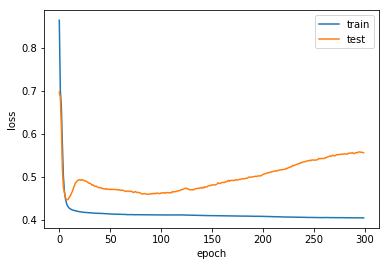

acc:
0.747730482026764
val_acc:
0.6945329425800552


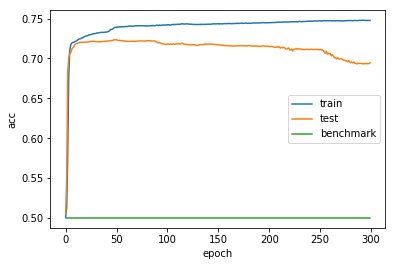

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6306 MiB, count=139, average=45.4 MiB
(2755200, 60, 5)
(2755200, 5, 60, 1)
[Training model......]
Train on 2044800 samples, validate on 2044800 samples
Epoch 1/300
2044800/2044800 [==============================] - 36s 18us/step - loss: 1.0592 - acc: 0.5004 - val_loss: 0.6998 - val_acc: 0.4993
Epoch 2/300
2044800/2044800 [==============================] - 28s 14us/step - loss: 0.7123 - acc: 0.5026 - val_loss: 0.6930 - val_acc: 0.5067
Epoch 3/300
2044800/2044800 [==============================] - 28s 14us/step - loss: 0.6974 - acc: 0.5092 - val_loss: 0.6905 - val_acc: 0.5171
Epoch 4/300
2044800/2044800 [==============================] - 28s 14us/step - loss: 0.6892 - acc: 0.5281 - val_loss: 0.6785 - val_acc: 0.5412
Epoch 5/300
2044800/2044800 [==============================] - 28s 14us/step - loss: 0.6525 - acc: 0.6037 - 

Epoch 56/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4201 - acc: 0.7244 - val_loss: 0.4646 - val_acc: 0.7109
Epoch 57/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4205 - acc: 0.7247 - val_loss: 0.4641 - val_acc: 0.7125
Epoch 58/300
2044800/2044800 [==============================] - 28s 14us/step - loss: 0.4207 - acc: 0.7245 - val_loss: 0.4638 - val_acc: 0.7132
Epoch 59/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4210 - acc: 0.7248 - val_loss: 0.4645 - val_acc: 0.7139
Epoch 60/300
2044800/2044800 [==============================] - 28s 14us/step - loss: 0.4209 - acc: 0.7242 - val_loss: 0.4649 - val_acc: 0.7151
Epoch 61/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4210 - acc: 0.7248 - val_loss: 0.4631 - val_acc: 0.7150
Epoch 62/300
2044800/2044800 [==============================] - 28s 14us/step - loss: 0.4212 - acc: 0.7247 - val_loss: 0.4660 - val_acc:

Epoch 113/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4172 - acc: 0.7286 - val_loss: 0.4443 - val_acc: 0.7188
Epoch 114/300
2044800/2044800 [==============================] - 28s 14us/step - loss: 0.4172 - acc: 0.7289 - val_loss: 0.4440 - val_acc: 0.7189
Epoch 115/300
2044800/2044800 [==============================] - 28s 14us/step - loss: 0.4171 - acc: 0.7285 - val_loss: 0.4459 - val_acc: 0.7182
Epoch 116/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4174 - acc: 0.7291 - val_loss: 0.4452 - val_acc: 0.7189
Epoch 117/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4171 - acc: 0.7297 - val_loss: 0.4440 - val_acc: 0.7198
Epoch 118/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4172 - acc: 0.7291 - val_loss: 0.4443 - val_acc: 0.7195
Epoch 119/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4169 - acc: 0.7293 - val_loss: 0.4444 - v

2044800/2044800 [==============================] - 28s 14us/step - loss: 0.4167 - acc: 0.7303 - val_loss: 0.4519 - val_acc: 0.7193
Epoch 226/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4172 - acc: 0.7299 - val_loss: 0.4456 - val_acc: 0.7214
Epoch 227/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4172 - acc: 0.7302 - val_loss: 0.4454 - val_acc: 0.7217
Epoch 228/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4173 - acc: 0.7300 - val_loss: 0.4458 - val_acc: 0.7213
Epoch 229/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4172 - acc: 0.7296 - val_loss: 0.4475 - val_acc: 0.7208
Epoch 230/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4170 - acc: 0.7302 - val_loss: 0.4467 - val_acc: 0.7211
Epoch 231/300
2044800/2044800 [==============================] - 29s 14us/step - loss: 0.4169 - acc: 0.7299 - val_loss: 0.4482 - val_acc: 0.7212

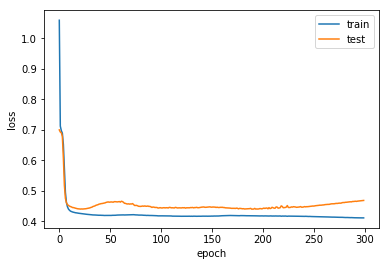

acc:
0.7321542449251214
val_acc:
0.7139461072062103


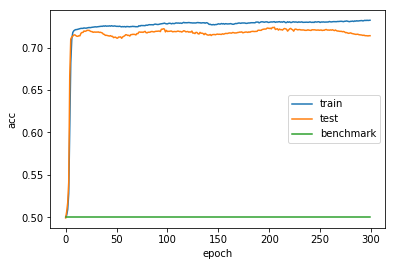

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6412 MiB, count=144, average=44.5 MiB
(2801280, 60, 5)
(2801280, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 2113920 samples
Epoch 1/300
2113920/2113920 [==============================] - 37s 18us/step - loss: 0.8853 - acc: 0.5011 - val_loss: 0.6946 - val_acc: 0.5236
Epoch 2/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.7051 - acc: 0.5077 - val_loss: 0.6902 - val_acc: 0.5273
Epoch 3/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6892 - acc: 0.5327 - val_loss: 0.6645 - val_acc: 0.6141
Epoch 4/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6322 - acc: 0.6281 - val_loss: 0.5246 - val_acc: 0.7140
Epoch 5/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.5186 - acc: 0.6970 - 

Epoch 56/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4302 - acc: 0.7182 - val_loss: 0.4401 - val_acc: 0.7186
Epoch 57/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4300 - acc: 0.7176 - val_loss: 0.4403 - val_acc: 0.7186
Epoch 58/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4300 - acc: 0.7177 - val_loss: 0.4404 - val_acc: 0.7186
Epoch 59/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4298 - acc: 0.7183 - val_loss: 0.4404 - val_acc: 0.7187
Epoch 60/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4299 - acc: 0.7183 - val_loss: 0.4407 - val_acc: 0.7184
Epoch 61/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4298 - acc: 0.7182 - val_loss: 0.4409 - val_acc: 0.7185
Epoch 62/300
2113920/2113920 [==============================] - 30s 14us/step - loss: 0.4296 - acc: 0.7183 - val_loss: 0.4412 - val_acc:

Epoch 113/300
2113920/2113920 [==============================] - 30s 14us/step - loss: 0.4288 - acc: 0.7194 - val_loss: 0.4366 - val_acc: 0.7214
Epoch 114/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4287 - acc: 0.7193 - val_loss: 0.4361 - val_acc: 0.7214
Epoch 115/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4288 - acc: 0.7194 - val_loss: 0.4362 - val_acc: 0.7211
Epoch 116/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4290 - acc: 0.7194 - val_loss: 0.4361 - val_acc: 0.7205
Epoch 117/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4290 - acc: 0.7189 - val_loss: 0.4366 - val_acc: 0.7196
Epoch 118/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4291 - acc: 0.7189 - val_loss: 0.4397 - val_acc: 0.7084
Epoch 119/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4298 - acc: 0.7188 - val_loss: 0.4459 - v

2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4291 - acc: 0.7192 - val_loss: 0.4470 - val_acc: 0.7105
Epoch 226/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4317 - acc: 0.7182 - val_loss: 0.4420 - val_acc: 0.7147
Epoch 227/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4295 - acc: 0.7199 - val_loss: 0.4451 - val_acc: 0.7124
Epoch 228/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4323 - acc: 0.7180 - val_loss: 0.4422 - val_acc: 0.7140
Epoch 229/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4291 - acc: 0.7196 - val_loss: 0.4437 - val_acc: 0.7069
Epoch 230/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4302 - acc: 0.7189 - val_loss: 0.4424 - val_acc: 0.7142
Epoch 231/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4295 - acc: 0.7193 - val_loss: 0.4433 - val_acc: 0.7068

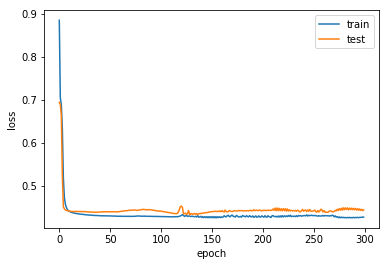

acc:
0.7198006547114505
val_acc:
0.7070371631813742


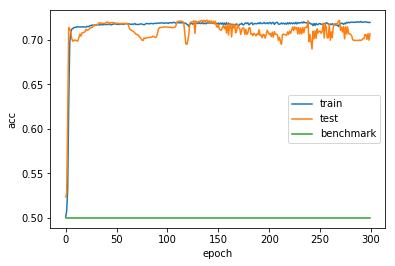

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6412 MiB, count=144, average=44.5 MiB
(2801280, 60, 5)
(2801280, 5, 60, 1)
[Training model......]
Train on 2090880 samples, validate on 2090880 samples
Epoch 1/300
2090880/2090880 [==============================] - 37s 18us/step - loss: 0.9590 - acc: 0.5025 - val_loss: 0.6943 - val_acc: 0.5096
Epoch 2/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.6945 - acc: 0.5290 - val_loss: 0.6813 - val_acc: 0.5666
Epoch 3/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.6569 - acc: 0.5879 - val_loss: 0.6457 - val_acc: 0.6292
Epoch 4/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.6157 - acc: 0.6457 - val_loss: 0.5770 - val_acc: 0.6852
Epoch 5/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.5571 - acc: 0.6782 - 

Epoch 56/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4289 - acc: 0.7136 - val_loss: 0.4469 - val_acc: 0.7041
Epoch 57/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4287 - acc: 0.7141 - val_loss: 0.4465 - val_acc: 0.7041
Epoch 58/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4288 - acc: 0.7139 - val_loss: 0.4463 - val_acc: 0.7042
Epoch 59/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4288 - acc: 0.7141 - val_loss: 0.4460 - val_acc: 0.7041
Epoch 60/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4283 - acc: 0.7142 - val_loss: 0.4464 - val_acc: 0.7046
Epoch 61/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4286 - acc: 0.7140 - val_loss: 0.4458 - val_acc: 0.7048
Epoch 62/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4286 - acc: 0.7140 - val_loss: 0.4464 - val_acc:

Epoch 113/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4275 - acc: 0.7153 - val_loss: 0.4399 - val_acc: 0.7042
Epoch 114/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4277 - acc: 0.7145 - val_loss: 0.4396 - val_acc: 0.7041
Epoch 115/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4276 - acc: 0.7150 - val_loss: 0.4396 - val_acc: 0.7042
Epoch 116/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4276 - acc: 0.7151 - val_loss: 0.4398 - val_acc: 0.7042
Epoch 117/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4277 - acc: 0.7153 - val_loss: 0.4397 - val_acc: 0.7044
Epoch 118/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4276 - acc: 0.7150 - val_loss: 0.4394 - val_acc: 0.7043
Epoch 119/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4275 - acc: 0.7148 - val_loss: 0.4395 - v

2090880/2090880 [==============================] - 28s 14us/step - loss: 0.4212 - acc: 0.7180 - val_loss: 0.4556 - val_acc: 0.7052
Epoch 226/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4210 - acc: 0.7183 - val_loss: 0.4562 - val_acc: 0.7052
Epoch 227/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4210 - acc: 0.7179 - val_loss: 0.4568 - val_acc: 0.7053
Epoch 228/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4207 - acc: 0.7182 - val_loss: 0.4575 - val_acc: 0.7052
Epoch 229/300
2090880/2090880 [==============================] - 29s 14us/step - loss: 0.4205 - acc: 0.7181 - val_loss: 0.4582 - val_acc: 0.7050
Epoch 230/300
2090880/2090880 [==============================] - 28s 14us/step - loss: 0.4203 - acc: 0.7188 - val_loss: 0.4585 - val_acc: 0.7052
Epoch 231/300
2090880/2090880 [==============================] - 28s 14us/step - loss: 0.4202 - acc: 0.7184 - val_loss: 0.4591 - val_acc: 0.7053

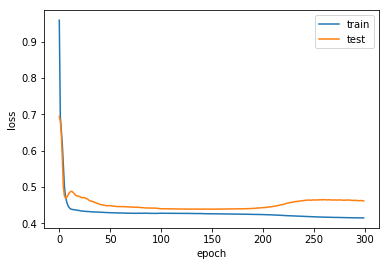

acc:
0.7221299165755483
val_acc:
0.7053049433585297


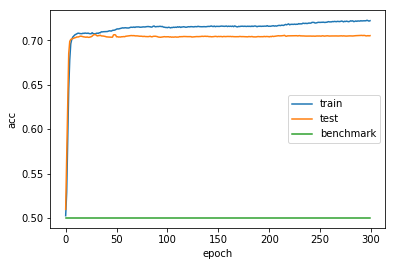

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6464 MiB, count=144, average=44.9 MiB
(2824320, 60, 5)
(2824320, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 2113920 samples
Epoch 1/300
2113920/2113920 [==============================] - 38s 18us/step - loss: 0.8859 - acc: 0.5024 - val_loss: 0.6928 - val_acc: 0.5211
Epoch 2/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6959 - acc: 0.5149 - val_loss: 0.6817 - val_acc: 0.5767
Epoch 3/300
2113920/2113920 [==============================] - 30s 14us/step - loss: 0.6690 - acc: 0.5653 - val_loss: 0.6079 - val_acc: 0.6764
Epoch 4/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.5796 - acc: 0.6563 - val_loss: 0.4927 - val_acc: 0.7068
Epoch 5/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4991 - acc: 0.6946 - 

Epoch 56/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4260 - acc: 0.7083 - val_loss: 0.4287 - val_acc: 0.7049
Epoch 57/300
2113920/2113920 [==============================] - 30s 14us/step - loss: 0.4260 - acc: 0.7084 - val_loss: 0.4287 - val_acc: 0.7051
Epoch 58/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4260 - acc: 0.7082 - val_loss: 0.4285 - val_acc: 0.7051
Epoch 59/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4259 - acc: 0.7083 - val_loss: 0.4288 - val_acc: 0.7051
Epoch 60/300
2113920/2113920 [==============================] - 30s 14us/step - loss: 0.4258 - acc: 0.7082 - val_loss: 0.4286 - val_acc: 0.7051
Epoch 61/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4257 - acc: 0.7085 - val_loss: 0.4287 - val_acc: 0.7046
Epoch 62/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4256 - acc: 0.7084 - val_loss: 0.4287 - val_acc:

Epoch 113/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4227 - acc: 0.7101 - val_loss: 0.4290 - val_acc: 0.7027
Epoch 114/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4228 - acc: 0.7100 - val_loss: 0.4289 - val_acc: 0.7030
Epoch 115/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4225 - acc: 0.7100 - val_loss: 0.4288 - val_acc: 0.7032
Epoch 116/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4227 - acc: 0.7098 - val_loss: 0.4289 - val_acc: 0.7027
Epoch 117/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4227 - acc: 0.7106 - val_loss: 0.4290 - val_acc: 0.7030
Epoch 118/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4223 - acc: 0.7106 - val_loss: 0.4289 - val_acc: 0.7033
Epoch 119/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4222 - acc: 0.7105 - val_loss: 0.4290 - v

2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4188 - acc: 0.7133 - val_loss: 0.4287 - val_acc: 0.7013
Epoch 226/300
2113920/2113920 [==============================] - 30s 14us/step - loss: 0.4187 - acc: 0.7133 - val_loss: 0.4288 - val_acc: 0.7010
Epoch 227/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4187 - acc: 0.7132 - val_loss: 0.4287 - val_acc: 0.7014
Epoch 228/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4186 - acc: 0.7132 - val_loss: 0.4288 - val_acc: 0.7013
Epoch 229/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4187 - acc: 0.7132 - val_loss: 0.4287 - val_acc: 0.7012
Epoch 230/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4186 - acc: 0.7131 - val_loss: 0.4286 - val_acc: 0.7022
Epoch 231/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4185 - acc: 0.7133 - val_loss: 0.4288 - val_acc: 0.7016

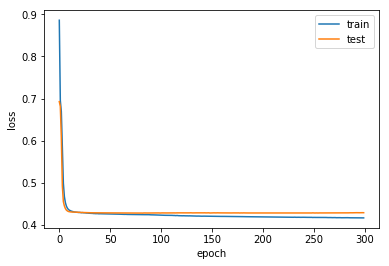

acc:
0.7127194974265819
val_acc:
0.7034972941229425


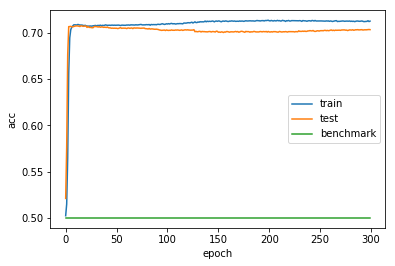

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
17
<ipython-input-13-727bc148a928>:46: size=6464 MiB, count=2, average=3232 MiB
(2801280, 60, 5)
(2801280, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 2113920 samples
Epoch 1/300
2113920/2113920 [==============================] - 38s 18us/step - loss: 0.8499 - acc: 0.5039 - val_loss: 0.6937 - val_acc: 0.5190
Epoch 2/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6964 - acc: 0.5170 - val_loss: 0.6825 - val_acc: 0.5545
Epoch 3/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6639 - acc: 0.5818 - val_loss: 0.6068 - val_acc: 0.6809
Epoch 4/300
2113920/2113920 [==============================] - 29s 13us/step - loss: 0.5738 - acc: 0.6721 - val_loss: 0.5106 - val_acc: 0.6980
Epoch 5/300
2113920/2113920 [==============================] - 28s 13us/step - loss: 0.5032 - acc: 0.7006 - val_loss: 0.4825 - val_acc: 0.6994
Epoc

2113920/2113920 [==============================] - 28s 13us/step - loss: 0.4266 - acc: 0.7106 - val_loss: 0.4544 - val_acc: 0.7025
Epoch 57/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4267 - acc: 0.7108 - val_loss: 0.4538 - val_acc: 0.7025
Epoch 58/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4265 - acc: 0.7107 - val_loss: 0.4542 - val_acc: 0.7024
Epoch 59/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4262 - acc: 0.7106 - val_loss: 0.4538 - val_acc: 0.7025
Epoch 60/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4263 - acc: 0.7113 - val_loss: 0.4536 - val_acc: 0.7029
Epoch 61/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4262 - acc: 0.7110 - val_loss: 0.4534 - val_acc: 0.7024
Epoch 62/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4263 - acc: 0.7109 - val_loss: 0.4532 - val_acc: 0.7026
Epoch

Epoch 113/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4234 - acc: 0.7166 - val_loss: 0.4403 - val_acc: 0.7116
Epoch 114/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4234 - acc: 0.7167 - val_loss: 0.4398 - val_acc: 0.7123
Epoch 115/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4234 - acc: 0.7174 - val_loss: 0.4398 - val_acc: 0.7125
Epoch 116/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4234 - acc: 0.7165 - val_loss: 0.4394 - val_acc: 0.7124
Epoch 117/300
2113920/2113920 [==============================] - 28s 13us/step - loss: 0.4234 - acc: 0.7172 - val_loss: 0.4397 - val_acc: 0.7129
Epoch 118/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4233 - acc: 0.7171 - val_loss: 0.4389 - val_acc: 0.7131
Epoch 119/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4232 - acc: 0.7176 - val_loss: 0.4391 - v

2113920/2113920 [==============================] - 28s 13us/step - loss: 0.4204 - acc: 0.7165 - val_loss: 0.4305 - val_acc: 0.7177
Epoch 226/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4203 - acc: 0.7163 - val_loss: 0.4305 - val_acc: 0.7178
Epoch 227/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4203 - acc: 0.7168 - val_loss: 0.4304 - val_acc: 0.7176
Epoch 228/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4202 - acc: 0.7163 - val_loss: 0.4304 - val_acc: 0.7177
Epoch 229/300
2113920/2113920 [==============================] - 29s 13us/step - loss: 0.4201 - acc: 0.7170 - val_loss: 0.4303 - val_acc: 0.7177
Epoch 230/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4201 - acc: 0.7169 - val_loss: 0.4303 - val_acc: 0.7178
Epoch 231/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4201 - acc: 0.7166 - val_loss: 0.4303 - val_acc: 0.7177

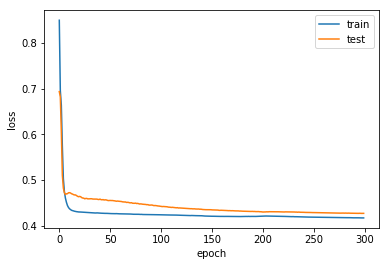

acc:
0.7195400015137754
val_acc:
0.7197424689676052


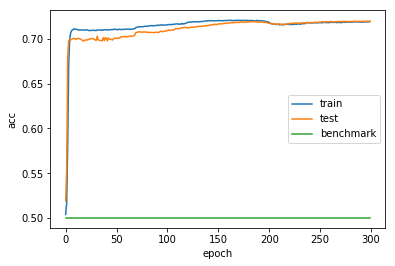

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
18
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6464 MiB, count=144, average=44.9 MiB
(2824320, 60, 5)
(2824320, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 2113920 samples
Epoch 1/300
2113920/2113920 [==============================] - 39s 18us/step - loss: 0.9258 - acc: 0.5039 - val_loss: 0.6895 - val_acc: 0.5364
Epoch 2/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6986 - acc: 0.5212 - val_loss: 0.6711 - val_acc: 0.5975
Epoch 3/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6610 - acc: 0.5783 - val_loss: 0.6143 - val_acc: 0.6649
Epoch 4/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6035 - acc: 0.6596 - val_loss: 0.5423 - val_acc: 0.7063
Epoch 5/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.5440 - acc: 0.6924 - 

Epoch 56/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4192 - acc: 0.7176 - val_loss: 0.4782 - val_acc: 0.7219
Epoch 57/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4192 - acc: 0.7178 - val_loss: 0.4781 - val_acc: 0.7219
Epoch 58/300
2113920/2113920 [==============================] - 28s 13us/step - loss: 0.4191 - acc: 0.7179 - val_loss: 0.4779 - val_acc: 0.7216
Epoch 59/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4189 - acc: 0.7182 - val_loss: 0.4784 - val_acc: 0.7217
Epoch 60/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4189 - acc: 0.7178 - val_loss: 0.4778 - val_acc: 0.7216
Epoch 61/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4189 - acc: 0.7176 - val_loss: 0.4769 - val_acc: 0.7216
Epoch 62/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4187 - acc: 0.7181 - val_loss: 0.4779 - val_acc:

Epoch 113/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4170 - acc: 0.7231 - val_loss: 0.4489 - val_acc: 0.7223
Epoch 114/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4168 - acc: 0.7225 - val_loss: 0.4490 - val_acc: 0.7221
Epoch 115/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4170 - acc: 0.7230 - val_loss: 0.4486 - val_acc: 0.7222
Epoch 116/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4170 - acc: 0.7229 - val_loss: 0.4480 - val_acc: 0.7223
Epoch 117/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4172 - acc: 0.7232 - val_loss: 0.4472 - val_acc: 0.7223
Epoch 118/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4171 - acc: 0.7233 - val_loss: 0.4473 - val_acc: 0.7226
Epoch 119/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4171 - acc: 0.7232 - val_loss: 0.4471 - v

2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4202 - acc: 0.7215 - val_loss: 0.4331 - val_acc: 0.7246
Epoch 226/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4204 - acc: 0.7221 - val_loss: 0.4331 - val_acc: 0.7245
Epoch 227/300
2113920/2113920 [==============================] - 29s 13us/step - loss: 0.4204 - acc: 0.7215 - val_loss: 0.4331 - val_acc: 0.7245
Epoch 228/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4201 - acc: 0.7218 - val_loss: 0.4327 - val_acc: 0.7246
Epoch 229/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4203 - acc: 0.7219 - val_loss: 0.4320 - val_acc: 0.7249
Epoch 230/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4203 - acc: 0.7220 - val_loss: 0.4328 - val_acc: 0.7248
Epoch 231/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.4202 - acc: 0.7225 - val_loss: 0.4330 - val_acc: 0.7250

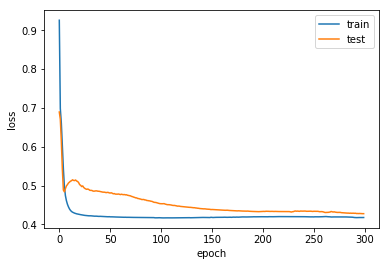

acc:
0.7236844346012955
val_acc:
0.7253647252461638


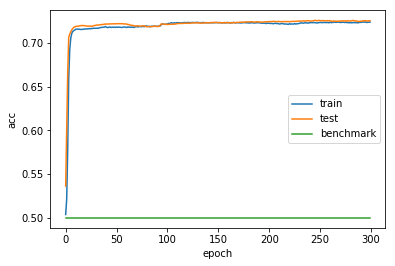

(None, 5, 1, 10)
(None, 5, 1, 6)
(None, 5, 1, 16)
g_MLP
drop_out
compile model success
19
<ipython-input-13-727bc148a928>:46: size=6464 MiB, count=2, average=3232 MiB
(2801280, 60, 5)
(2801280, 5, 60, 1)
[Training model......]
Train on 2113920 samples, validate on 2113920 samples
Epoch 1/300
2113920/2113920 [==============================] - 40s 19us/step - loss: 0.9005 - acc: 0.5053 - val_loss: 0.6845 - val_acc: 0.5425
Epoch 2/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6867 - acc: 0.5481 - val_loss: 0.6442 - val_acc: 0.6606
Epoch 3/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.6358 - acc: 0.6369 - val_loss: 0.5630 - val_acc: 0.7208
Epoch 4/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.5592 - acc: 0.6968 - val_loss: 0.4639 - val_acc: 0.7315
Epoch 5/300
2113920/2113920 [==============================] - 30s 14us/step - loss: 0.4737 - acc: 0.7239 - val_loss: 0.4220 - val_acc: 0.7390
Epoc

2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3945 - acc: 0.7418 - val_loss: 0.4008 - val_acc: 0.7492
Epoch 57/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3947 - acc: 0.7418 - val_loss: 0.4005 - val_acc: 0.7492
Epoch 58/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3948 - acc: 0.7419 - val_loss: 0.4004 - val_acc: 0.7493
Epoch 59/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3946 - acc: 0.7421 - val_loss: 0.4003 - val_acc: 0.7494
Epoch 60/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3946 - acc: 0.7420 - val_loss: 0.4002 - val_acc: 0.7492
Epoch 61/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3946 - acc: 0.7422 - val_loss: 0.3999 - val_acc: 0.7494
Epoch 62/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3946 - acc: 0.7422 - val_loss: 0.3999 - val_acc: 0.7494
Epoch

Epoch 113/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3935 - acc: 0.7444 - val_loss: 0.3967 - val_acc: 0.7475
Epoch 114/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3937 - acc: 0.7442 - val_loss: 0.3968 - val_acc: 0.7473
Epoch 115/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3934 - acc: 0.7440 - val_loss: 0.3968 - val_acc: 0.7483
Epoch 116/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3936 - acc: 0.7437 - val_loss: 0.3967 - val_acc: 0.7484
Epoch 117/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3936 - acc: 0.7440 - val_loss: 0.3966 - val_acc: 0.7485
Epoch 118/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3936 - acc: 0.7441 - val_loss: 0.3967 - val_acc: 0.7476
Epoch 119/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3935 - acc: 0.7437 - val_loss: 0.3966 - v

2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3909 - acc: 0.7468 - val_loss: 0.3961 - val_acc: 0.7497
Epoch 226/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3908 - acc: 0.7471 - val_loss: 0.3962 - val_acc: 0.7497
Epoch 227/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3908 - acc: 0.7473 - val_loss: 0.3961 - val_acc: 0.7497
Epoch 228/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3908 - acc: 0.7472 - val_loss: 0.3963 - val_acc: 0.7497
Epoch 229/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3907 - acc: 0.7473 - val_loss: 0.3962 - val_acc: 0.7495
Epoch 230/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3906 - acc: 0.7472 - val_loss: 0.3961 - val_acc: 0.7495
Epoch 231/300
2113920/2113920 [==============================] - 29s 14us/step - loss: 0.3905 - acc: 0.7473 - val_loss: 0.3962 - val_acc: 0.7494

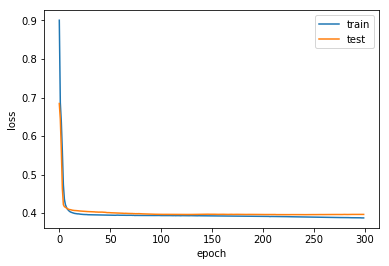

acc:
0.749077070087799
val_acc:
0.7499087004274663


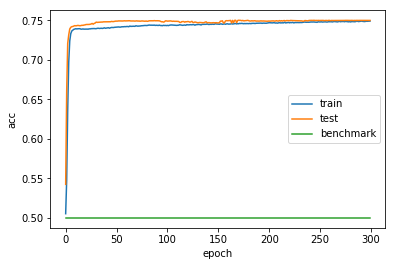

train_acc:red,test_acc:blue


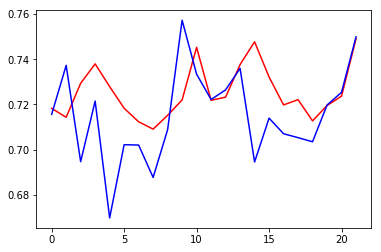

train_loss:red,test_loss:blue


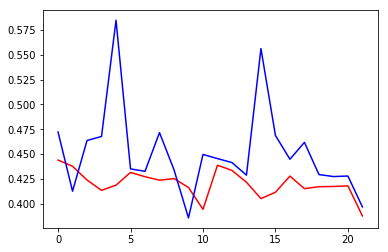

trend:red,vol:blue


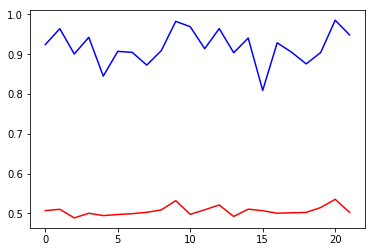

In [14]:
for i in range(9,20,1):

    MLP_unit=64
    visual_scene = Input((currencynum,l,1))
    visual_conv = ConvolutionNetworks([20,10],[(1,5),(1,5)])(visual_scene)
    print(K.int_shape(visual_conv))
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([tag, visual_conv])
    print(K.int_shape(visual_conv))
    
    shapes = visual_conv.shape
    w = shapes[1]
    f = shapes[2]
    features= []
    #features = np.zeros(0)
    for k1 in range(w):
        for k2 in range(f):
            def get_feature(t):
                return t[:, k1, k2, :]
            #get_feature_layer = Lambda(get_feature)
            features.append(Lambda(get_feature)(visual_conv))
    
      
    input2 = Input((14,))
    onehot_encode_question = input2
    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode_question]))    
    
     
    g_MLP = get_MLP(4, get_dense(4,MLP_unit))
    
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))
    
    combined_relation = Add()(mid_relations)
    
    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')
    
    pred = Dense(1, activation = 'sigmoid')(rn)
    
    
    #model = Model(inputs=[visual_scene])
    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(i)
    fit_show(Train_data,month[i],month[i+3],month[i+4])

print("train_acc:red,test_acc:blue")    
plt.plot(lastepoch_train_acc,color='r')
plt.plot(lastepoch_test_acc,color='b')
plt.show()
print("train_loss:red,test_loss:blue")
plt.plot(lastepoch_train_loss,color='r')
plt.plot(lastepoch_test_loss,color='b')
plt.show()
print("trend:red,vol:blue")
plt.plot(total_test_trend,color='r')
plt.plot(total_test_vol,color='b')
plt.show()